In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast
from typing import Dict, Tuple
from transformers import AutoModelForSequenceClassification
from peft import PeftModel


In [2]:
def evaluate_llm_classifier(base_model_path: str, lora_adapter_path: str, test_data: pd.DataFrame, tokenizer: PreTrainedTokenizerFast) -> Tuple[Dict[str, float | int], Dict[str, float]]:

    base_model = AutoModelForSequenceClassification.from_pretrained(
        base_model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        num_labels=2
    )

    model = PeftModel.from_pretrained(
        base_model,
        lora_adapter_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

    tokenizer.chat_template = None

    tokenizer.chat_template = """{% for message in messages %} {{ message['role'] }} {{ message['content'] }} {% endfor %}"""

    true_labels = []
    predicted_labels = []

    for _, row in test_data.iterrows():
        messages = [
            {"role": "system", "content": row["system"]},
            {"role": "user", "content": row["user"]},
            {"role": "assistant", "content": ""}
        ]

        prompt = tokenizer.apply_chat_template(messages, tokenize=False)

        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)

            logits = outputs.logits
            predictions = torch.softmax(logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=-1)

        pred_label = bool(predicted_class[0])
        true_label = row["assistant"]

        true_labels.append(true_label)
        predicted_labels.append(pred_label)

    metrics = {
        "accuracy": accuracy_score(true_labels, predicted_labels),
        "precision": precision_score(true_labels, predicted_labels),
        "recall": recall_score(true_labels, predicted_labels),
        "f1_score": f1_score(true_labels, predicted_labels),
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

    evaluation_confusion_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(evaluation_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return metrics

In [3]:
test_df = pd.read_csv("../processed_data/test.csv")

In [4]:
base_model_path = "../models/llama_models/llama-3.2-3B"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)

# Checkpoint-467

In [6]:
checkpoint_467_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-467"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


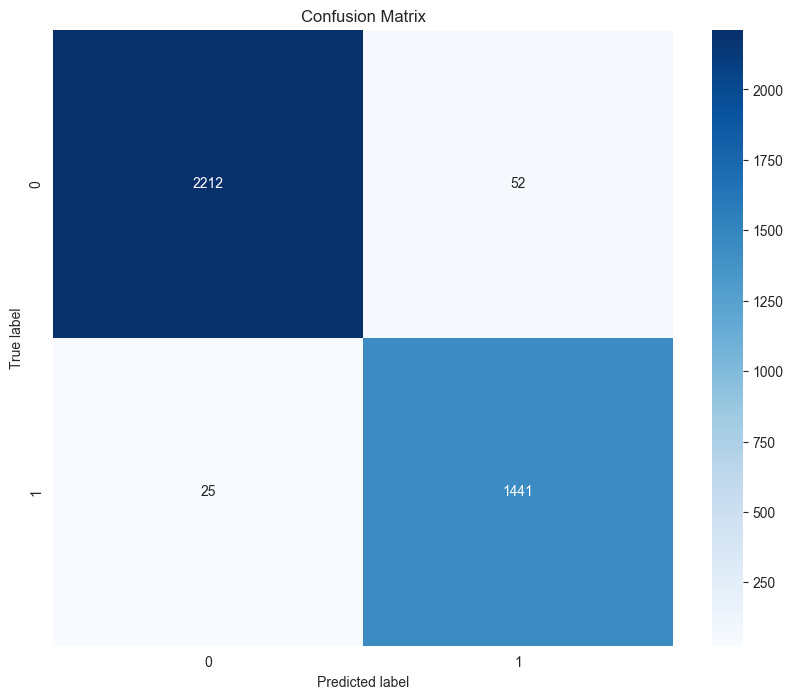

In [7]:
checkpoint_467_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_467_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [8]:
cls_report = classification_report(checkpoint_467_metrics["true_labels"], checkpoint_467_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       0.99      0.98      0.98      2264
    Phishing       0.97      0.98      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [9]:
print(f"Accuracy: {checkpoint_467_metrics['accuracy']}")
print(f"Precision: {checkpoint_467_metrics['precision']}")
print(f"Recall: {checkpoint_467_metrics['recall']}")
print(f"F1-score: {checkpoint_467_metrics['f1_score']}")


Accuracy: 0.9793565683646113
Precision: 0.9651707970529136
Recall: 0.9829467939972715
F1-score: 0.9739776951672863


# Checkpoint 934

In [10]:
checkpoint_934_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-934"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


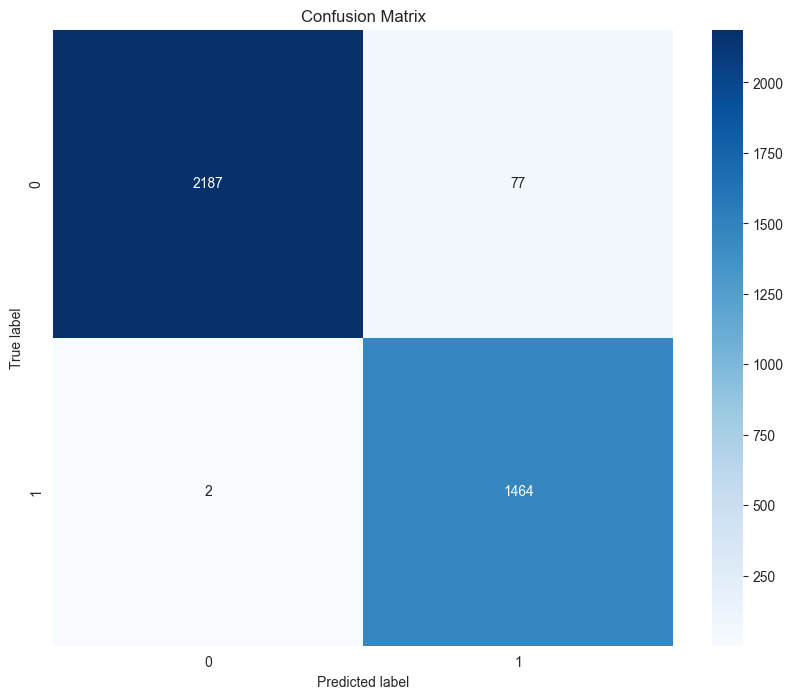

In [11]:
checkpoint_934_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_934_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [12]:
cls_report = classification_report(checkpoint_934_metrics["true_labels"], checkpoint_934_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.97      0.98      2264
    Phishing       0.95      1.00      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.97      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [13]:
print(f"Accuracy: {checkpoint_934_metrics['accuracy']}")
print(f"Precision: {checkpoint_934_metrics['precision']}")
print(f"Recall: {checkpoint_934_metrics['recall']}")
print(f"F1-score: {checkpoint_934_metrics['f1_score']}")

Accuracy: 0.9788203753351207
Precision: 0.9500324464633355
Recall: 0.9986357435197817
F1-score: 0.9737279680744928


# Checkpoint 1401

In [14]:
checkpoint_1401_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-1401"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


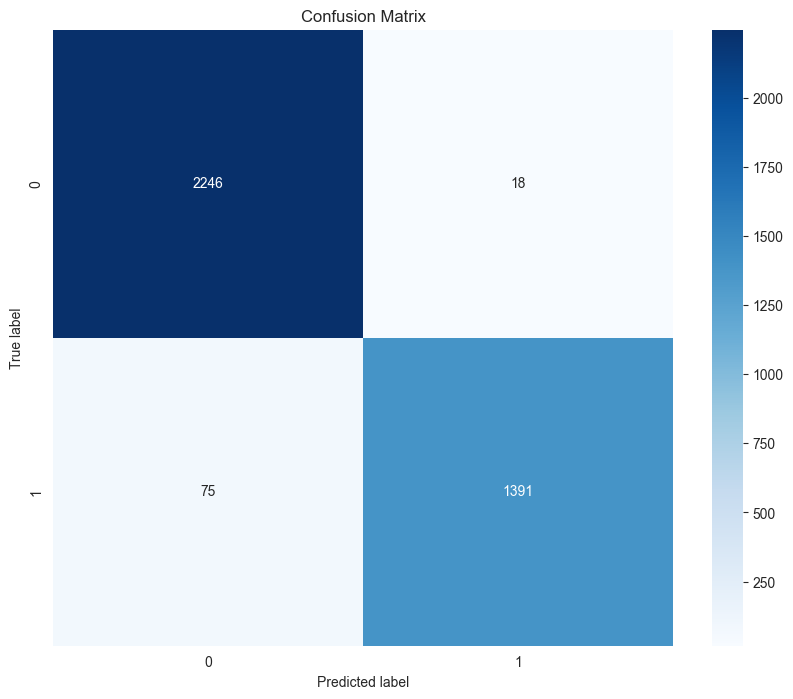

In [15]:
checkpoint_1401_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_1401_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [16]:
cls_report = classification_report(checkpoint_1401_metrics["true_labels"], checkpoint_1401_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       0.97      0.99      0.98      2264
    Phishing       0.99      0.95      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.97      0.97      3730
weighted avg       0.98      0.98      0.97      3730



In [17]:
print(f"Accuracy: {checkpoint_1401_metrics['accuracy']}")
print(f"Precision: {checkpoint_1401_metrics['precision']}")
print(f"Recall: {checkpoint_1401_metrics['recall']}")
print(f"F1-score: {checkpoint_1401_metrics['f1_score']}")

Accuracy: 0.9750670241286863
Precision: 0.9872249822569198
Recall: 0.9488403819918144
F1-score: 0.9676521739130435


# Checkpoint 1868

In [18]:
checkpoint_1868_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-1868"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


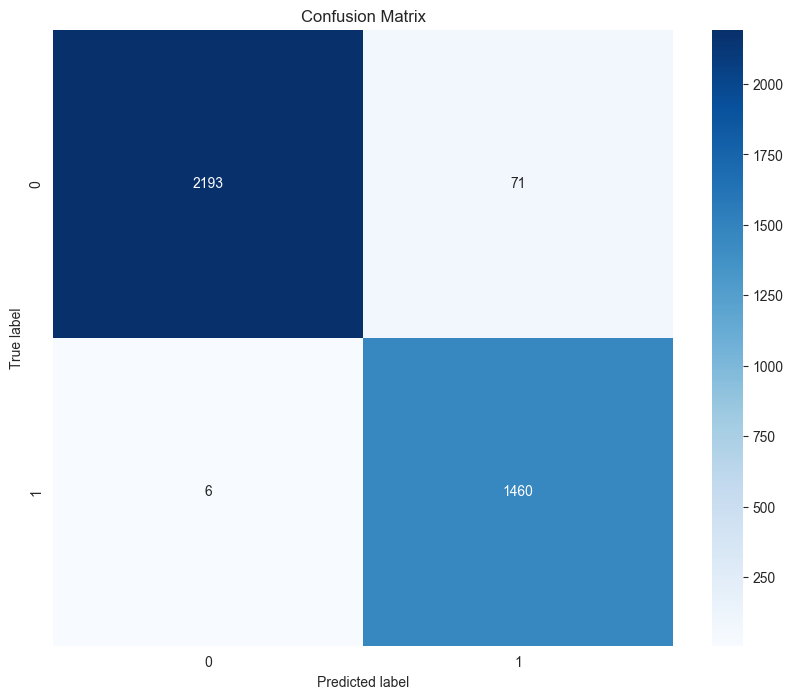

In [19]:
checkpoint_1868_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_1868_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [20]:
cls_report = classification_report(checkpoint_1868_metrics["true_labels"], checkpoint_1868_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.97      0.98      2264
    Phishing       0.95      1.00      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [21]:
print(f"Accuracy: {checkpoint_1868_metrics['accuracy']}")
print(f"Precision: {checkpoint_1868_metrics['precision']}")
print(f"Recall: {checkpoint_1868_metrics['recall']}")
print(f"F1-score: {checkpoint_1868_metrics['f1_score']}")

Accuracy: 0.9793565683646113
Precision: 0.953625081645983
Recall: 0.9959072305593452
F1-score: 0.9743076409743077


# Checkpoint 2335

In [22]:
checkpoint_2335_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-2335"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


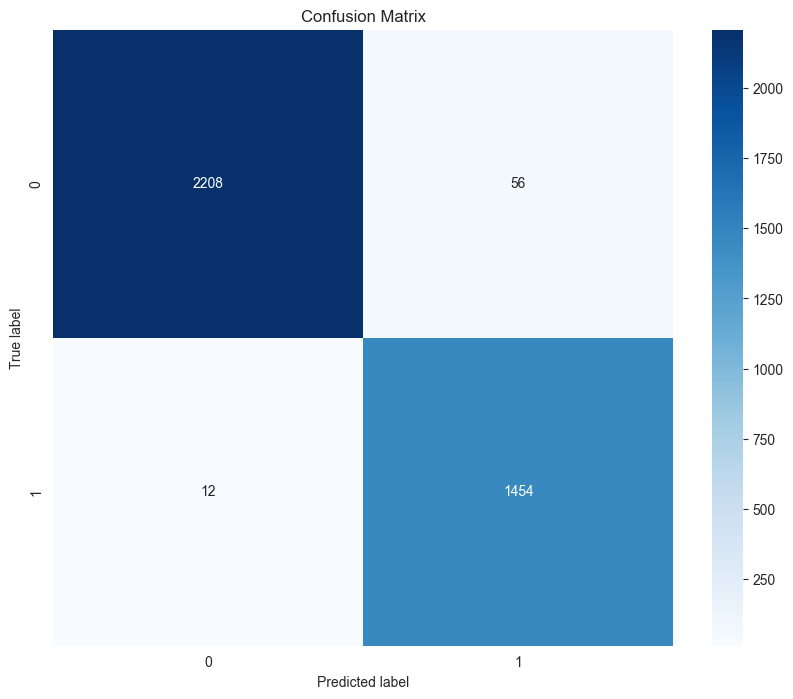

In [23]:
checkpoint_2335_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_2335_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [24]:
cls_report = classification_report(checkpoint_2335_metrics["true_labels"], checkpoint_2335_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       0.99      0.98      0.98      2264
    Phishing       0.96      0.99      0.98      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [25]:
print(f"Accuracy: {checkpoint_2335_metrics['accuracy']}")
print(f"Precision: {checkpoint_2335_metrics['precision']}")
print(f"Recall: {checkpoint_2335_metrics['recall']}")
print(f"F1-score: {checkpoint_2335_metrics['f1_score']}")

Accuracy: 0.981769436997319
Precision: 0.9629139072847682
Recall: 0.9918144611186903
F1-score: 0.9771505376344086


# Checkpoint 2802

In [26]:
checkpoint_2802_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-2802"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


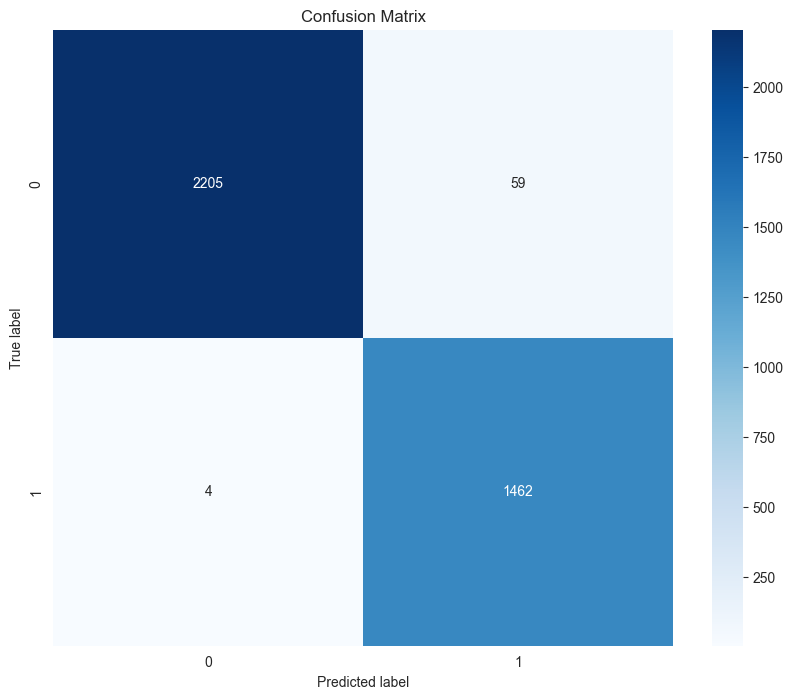

In [27]:
checkpoint_2802_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_2802_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [28]:
cls_report = classification_report(checkpoint_2802_metrics["true_labels"], checkpoint_2802_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.97      0.99      2264
    Phishing       0.96      1.00      0.98      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.99      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [29]:
print(f"Accuracy: {checkpoint_2802_metrics['accuracy']}")
print(f"Precision: {checkpoint_2802_metrics['precision']}")
print(f"Recall: {checkpoint_2802_metrics['recall']}")
print(f"F1-score: {checkpoint_2802_metrics['f1_score']}")

Accuracy: 0.9831099195710455
Precision: 0.9612097304404996
Recall: 0.9972714870395635
F1-score: 0.978908603950452


# Checkpoint 3269

In [30]:
checkpoint_3269_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-3269"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


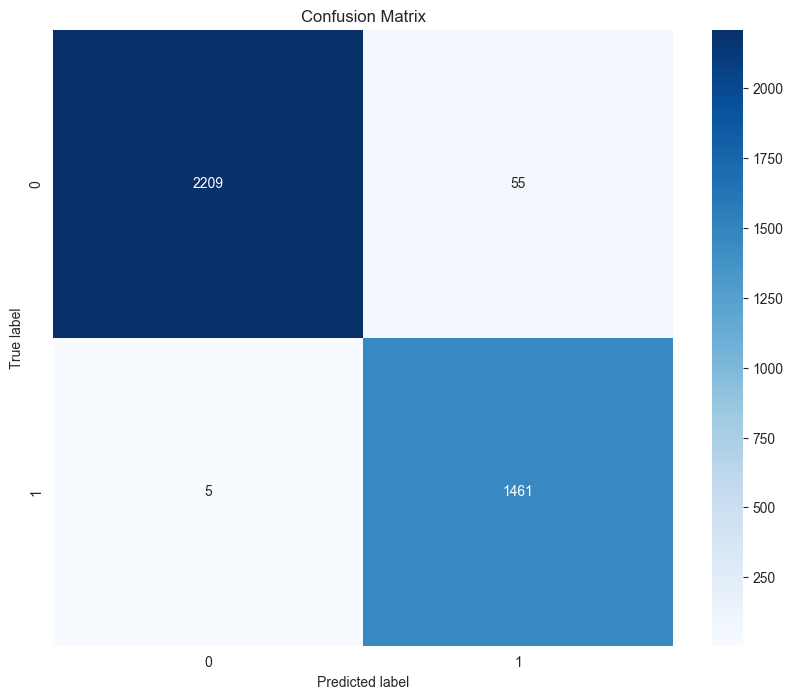

In [31]:
checkpoint_3269_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_3269_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [32]:
cls_report = classification_report(checkpoint_3269_metrics["true_labels"], checkpoint_3269_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.98      0.99      2264
    Phishing       0.96      1.00      0.98      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.99      0.98      3730
weighted avg       0.98      0.98      0.98      3730



In [33]:
print(f"Accuracy: {checkpoint_3269_metrics['accuracy']}")
print(f"Precision: {checkpoint_3269_metrics['precision']}")
print(f"Recall: {checkpoint_3269_metrics['recall']}")
print(f"F1-score: {checkpoint_3269_metrics['f1_score']}")

Accuracy: 0.9839142091152815
Precision: 0.9637203166226913
Recall: 0.9965893587994543
F1-score: 0.9798792756539235


# Checkpoint 3736

In [34]:
checkpoint_3736_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-3736"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


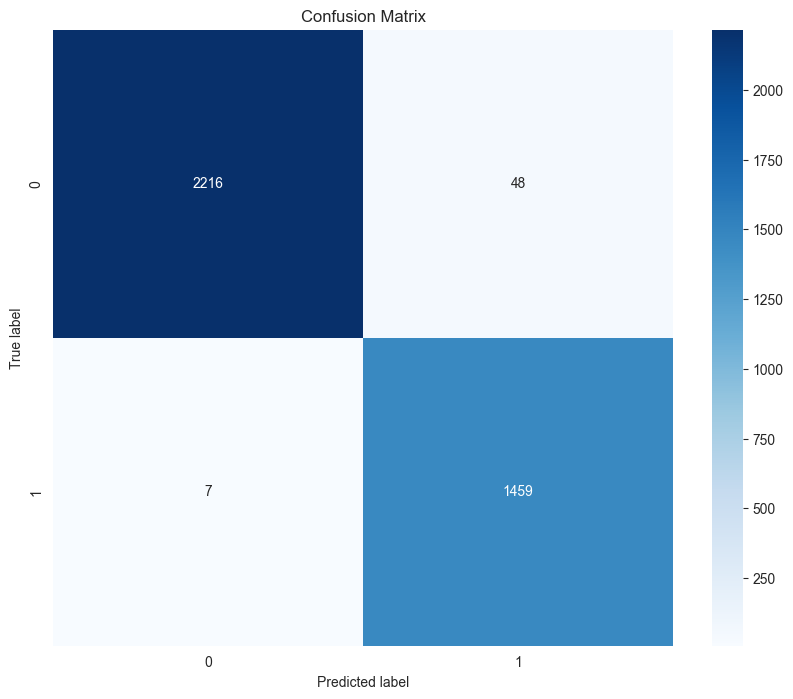

In [35]:
checkpoint_3736_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_3736_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [36]:
cls_report = classification_report(checkpoint_3736_metrics["true_labels"], checkpoint_3736_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.98      0.99      2264
    Phishing       0.97      1.00      0.98      1466

    accuracy                           0.99      3730
   macro avg       0.98      0.99      0.98      3730
weighted avg       0.99      0.99      0.99      3730



In [37]:
print(f"Accuracy: {checkpoint_3736_metrics['accuracy']}")
print(f"Precision: {checkpoint_3736_metrics['precision']}")
print(f"Recall: {checkpoint_3736_metrics['recall']}")
print(f"F1-score: {checkpoint_3736_metrics['f1_score']}")

Accuracy: 0.985254691689008
Precision: 0.9681486396814863
Recall: 0.995225102319236
F1-score: 0.9815001681802893


# Checkpoint 4203

In [38]:
checkpoint_4203_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-4203"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


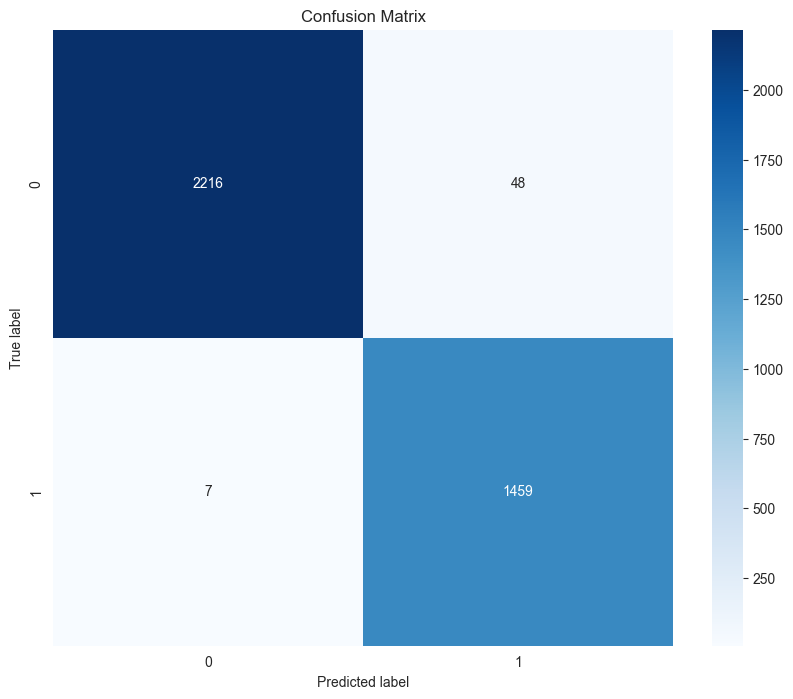

In [39]:
checkpoint_4203_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_4203_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [40]:
cls_report = classification_report(checkpoint_4203_metrics["true_labels"], checkpoint_4203_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.98      0.99      2264
    Phishing       0.97      1.00      0.98      1466

    accuracy                           0.99      3730
   macro avg       0.98      0.99      0.98      3730
weighted avg       0.99      0.99      0.99      3730



In [41]:
print(f"Accuracy: {checkpoint_4203_metrics['accuracy']}")
print(f"Precision: {checkpoint_4203_metrics['precision']}")
print(f"Recall: {checkpoint_4203_metrics['recall']}")
print(f"F1-score: {checkpoint_4203_metrics['f1_score']}")

Accuracy: 0.985254691689008
Precision: 0.9681486396814863
Recall: 0.995225102319236
F1-score: 0.9815001681802893


# Checkpoint 4660

In [42]:
checkpoint_4660_adapter_path = "../models/tuned_models/llama-3.2-3B-phishing-classifier-seq-cls-v3/checkpoint-4660"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ../models/llama_models/llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


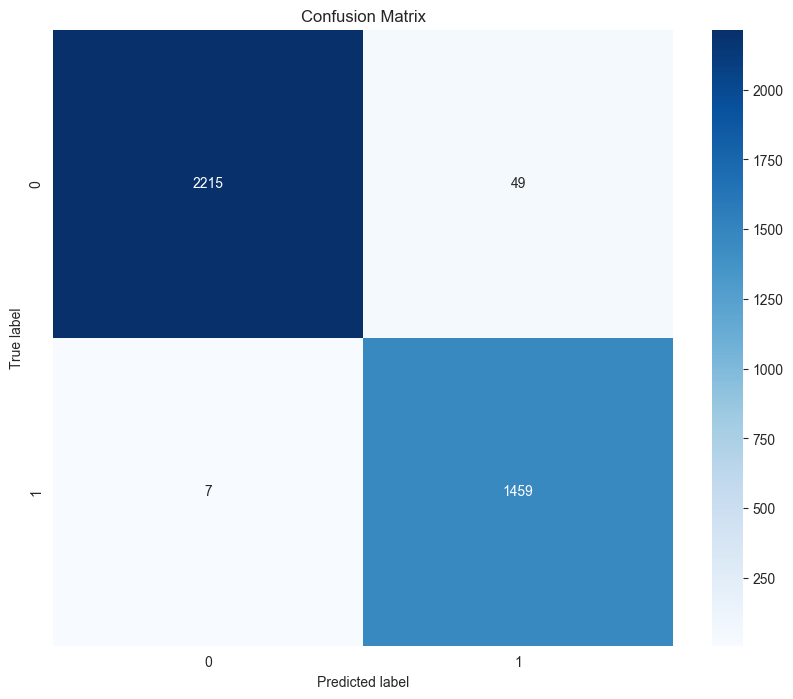

In [43]:
checkpoint_4660_metrics = evaluate_llm_classifier(
    base_model_path=base_model_path,
    lora_adapter_path=checkpoint_4660_adapter_path,
    test_data=test_df,
    tokenizer=tokenizer
)

In [44]:
cls_report = classification_report(checkpoint_4660_metrics["true_labels"], checkpoint_4660_metrics["predicted_labels"], target_names=["Safe", "Phishing"])

print(cls_report)

              precision    recall  f1-score   support

        Safe       1.00      0.98      0.99      2264
    Phishing       0.97      1.00      0.98      1466

    accuracy                           0.98      3730
   macro avg       0.98      0.99      0.98      3730
weighted avg       0.99      0.98      0.99      3730



In [45]:
print(f"Accuracy: {checkpoint_4660_metrics['accuracy']}")
print(f"Precision: {checkpoint_4660_metrics['precision']}")
print(f"Recall: {checkpoint_4660_metrics['recall']}")
print(f"F1-score: {checkpoint_4660_metrics['f1_score']}")

Accuracy: 0.9849865951742627
Precision: 0.9675066312997348
Recall: 0.995225102319236
F1-score: 0.9811701412239409
